# Desafío final: Asignador de giro a comisiones para proyectos de ley
## El problema:
A la Cámara de Diputados ingresan proyectos de ley sobre distintos asuntos.  Al ingresar se redacta un título para el proyecto, y un breve sumario, y se lo envía (o "gira") a una o más comisiones de estudio de acuerdo al tema del proyecto.

Las comisiones de estudio son 45; están formadas por grupos de veinte a cuarenta y cinco diputados y cada una se especializa en un tema determinado (educación, salud, medio ambiente, economía, etc).

En promedio cada proyecto es girado a 2 o 3 comisiones.

Una vez que las comisiones a las que fue girado un proyecto emiten un dictamen sobre el mismo, éste está en condiciones de ser tratado en el recinto de la Cámara.

## El desafío:

El desafío propuesto es hacer un clasificador que entrene con hasta 40 mil proyectos que ya fueron girados a comisiones en el pasado y pueda sugerir a qué comisiones deben asignarse los nuevos proyectos que ingresan.

Consideramos las 45 comisiones a las que puede ser asignado cada proyecto, como una etiqueta. Y dado que a cada proyecto puede asignarse a más de una comisión, estamos ante un problema de clasificación **multi-label**.

Scikit-learn provee una librería específica para problemas de clasificación multi-label: ** scikit-multilearn**.

En este desafío vamos a probar distintos clasificadores para comparar su desempeño.


*** Referencia: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/ ***

## Importación de las librerías a utilizar:

In [ ]:
#!pip install scikit-multilearn
#!pip install stop_words
#!pip install spacy


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import csr_matrix

from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import BinaryRelevance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import hamming_loss

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import f1_score
import scipy as scipy

from sklearn.metrics import jaccard_similarity_score

from sklearn.metrics import classification_report

%matplotlib inline



## Los datos:
El dataset de proyectos se compone de los siguientes campos, todos de texto:
* **EXPEDIENTE:**  string de números y letras que identifica a cada proyecto.
* **TITULO:** breve descripción del asunto. (Solo en el dataset alternativo)
* **SUMARIO:** breve descripción del texto del proyecto.
* **VOCES:** palabras o expresiones que se asignan para facilitar la búsqueda y recuperación de los proyectos.  (No hay separadores). (Solo en el dataset alternativo)
* **GIRO_INICIADORA:** string con la/s comisión/es a la/s que se envia el proyecto para su estudio.  Separadas por puntos y comas.

El dataset de comisiones se compone de los siguientes campos,
* **ID_COMISION:** identificador numérico único
* **ORDEN:** para las 45 comisiones permanentes el número va de 1 a 45, y se repite únicamente para comisiones que han cambiado de nombre, ya que en estos casos el dataset contiene un registro por cada nombre que tuvo la comisión
* **NOMBRE:** nombre de la comisión
* **CAMARA:** en este caso vienn solamente las de la Cámara de Diputados
* **GRUPO:** indica si la comisión es bicameral ('CD'=Diputados, 'CS=Senado) o bicameral ('CB')
* **TIPO:** una P indica que es permanente, una E indica que es una comisión especial
* **FINALIZADA:** si es True indica que cambió de nombre, y comparte el número de orden con otro registro, que posee el nombre actual

In [ ]:
df = pd.read_csv("PL_DIPUTADOS_TODOS_GIRO_FIRMANTES_ME.csv",  encoding="utf-8")
df.head()

## Preparación de la lista de comisiones permanentes

In [ ]:
df_comisiones = pd.read_csv("comisiones_permanentes.txt", sep='\t', encoding="utf-8")
#print(df_comisiones.columns)

'''Se van a utilizar solamente el nombre de la comisión, el orden, y el booleano FINALIZADA para unificar con el mismo número de orden 
nombres diferentes que haya tenido una misma comisión a lo largo del tiempo:'''

df_comisiones = df_comisiones[['NOMBRE', 'ORDEN', 'FINALIZADA']]
df_comisiones.set_index('NOMBRE', inplace=True)

df_comisiones.head()

In [ ]:
#Confección de dos diccionario de comisiones
dict_comisiones = df_comisiones.transpose().to_dict()



def comision_vigente(x):
    #Cambia x por el orden de la comision usando el diccionario

    if isinstance(x, float):
        comision = x
    else:
        if x in dict_comisiones:
            comision = dict_comisiones[x]['ORDEN']
        else:
            comision = 'OTRA COMISION'
    return comision

dict_comisiones_2 = df_comisiones[df_comisiones.FINALIZADA != True].sort_values('ORDEN').reset_index().set_index('ORDEN').transpose().to_dict()

def lista_comisiones():
    # devuelve la lista de las comisiones vigentes, sin duplicados en el numero de orden por cambio de nombre
    return df_comisiones[df_comisiones.FINALIZADA != True].sort_values(['ORDEN'])



## Datos de las comisiones ya preparados:

In [ ]:
print(lista_comisiones().head(4))

## Preparación del dataframe de proyectos (Sumario de la Mesa de Entradas)

#### Transformadores a utilizar en la preparación de datos:

In [ ]:
# TRANSFORMADOR
class DropNullsColumn(BaseEstimator, TransformerMixin):
    ''' Devuelve el dataset solo con las filas que no 
        tienen la columna del parámetro en null '''
    
    def __init__(self,column_name):        
        self.column_name = column_name
    
    def transform(self, X):
            X = X[X[self.column_name].notnull()]
            return X
    
    def fit(self, *_):
        return self 
    
# TRANSFORMADOR
class TextReplacer(BaseEstimator, TransformerMixin):
    ''' Extrae el texto <<valor>> de la columna <<col_name_1>> y lo reemplaza con el texto de <<nuevo_valor>>'''
    
    def __init__(self,col_name_1, valor, nuevo_valor):        
        self.col_name_1 = col_name_1        
        self.valor = valor
        self.nuevo_valor = nuevo_valor
    
    def transform(self, X):
           # X[self.col_name_2] = X[self.col_name_1].str.extract(self.valor, expand=False)
            X[self.col_name_1] = X[self.col_name_1].str.replace(self.valor,self.nuevo_valor).str.strip()
            return X
    
    def fit(self, *_):
        return self 
    
# TRANSFORMADOR
def drop(columns):
    ''' Devuelve un transformador que elimina las columnas pasadas como parámetros del dataframe '''
    return FunctionTransformer(lambda X: X.drop(columns=columns), validate=False)

# TRANSFORMADOR
def getDummies(col, drop_first):
    return FunctionTransformer(lambda X: pd.get_dummies(X, drop_first=drop_first))

# TRANSFORMADOR
def extract(columns):
    return FunctionTransformer(lambda X: X[columns], validate=False)

# TRANSFORMADOR
def dropRows(column, value):
    ''' Elimina las filas que tienen <<valor>> en la columna pasda como parámetro '''
    return FunctionTransformer(lambda X: X.loc[X[column]!=value], validate=False)

# TRANSFORMADOR
def dropAllNulls(axis):
    ''' Llena con ceros las columnas de dummies que tienen todo null '''
    return FunctionTransformer(lambda X: X.fillna(0).astype('int'), validate=False)



# TRANSFORMADOR
class Splitter(BaseEstimator, TransformerMixin):
    ''' Hace un split de la columna <<column_name>> y pone los valores en dos columnas nuevas
       con nombres <<name1>> y <<name2>>'''
    
    def __init__(self,column_name, loops, sep):        
        self.column_name = column_name
        self.loops = loops
        self.sep = sep        
    
    def transform(self, X):           
            df2 = X[self.column_name].apply(lambda x: pd.Series(x.split(self.sep)))           
            X = X.join( df2[[0,1,2,3]])           
            return X
    
    def fit(self, *_):
        return self
    
# TRANSFORMADOR
class CorrectorGiroDoble(BaseEstimator, TransformerMixin):
    
    def __init__(self):        
           pass
        
    def transform(self, X):
        cols = X.filter(regex='^\d').columns
        X[cols] = X[cols].applymap(lambda x: x if x < 2 else 1)
        return X       
       
        
    def fit(self, *_):
        return self


# TRANSFORMADOR
class DictionaryTransformer(BaseEstimator, TransformerMixin):
    ''' Convierte los valores de la columna <<col_name>> otros según el diccionario pasado por parametro'''    
    
    def __init__(self,cols,dic):             
        self.dic = dic
        self.cols = cols        
        
    def comision_vigente(self, x):      
        if x in self.dic:
            comision = self.dic[x]['ORDEN']
        else:
            if x == 'NA':
                comision = np.nan
            else:
                comision = 'OTRA COMISION'
        return comision
        
    def transform(self, X):
            for i in self.cols:
                X[i] = X[i].fillna('NA').transform(self.comision_vigente)
            return X
    
    def fit(self, *_):
        return self
    
# TRANSFORMADOR
class MatrizDummies(BaseEstimator, TransformerMixin):
    ''' Hace la matriz de 0 y 1 con las multilabels '''   
    
    def __init__(self,cols):             
        self.cols = cols       
   
        
    def transform(self, X):            
            frames = {}
            for i in self.cols:
                frames[i] = pd.get_dummies(X[i])          
            temp = frames [i]
            for j in range(i - 1,-1,-1):
                temp = temp + frames[j]
            X = X.rename(columns={0: 'giro_1', 1: 'giro_2', 2: 'giro_3', 3: 'giro_4'})
            temp = temp.fillna(0).astype('int')
            X = X.join(temp, how='inner')
            return X
    
    def fit(self, *_):
        return self
    


#### Pipiline de preparación de datos:

In [ ]:
steps = [          
        ('extractor', extract(['EXPEDIENTE','TITULO', 'GIRO_INICIADORA'])),    
        ('dropper_1', DropNullsColumn('GIRO_INICIADORA')),
        ('delete_reproduccion', TextReplacer('TITULO', '(\(REPRODUCCION.*\))','')),
        ('comisiones_splitter', Splitter('GIRO_INICIADORA', 1,';')),
        ('comisiones_to_codes', DictionaryTransformer([0,1,2,3],dict_comisiones)),
        ('dropper_2', dropRows(0, 'OTRA COMISION')),
        ('dropper_3', dropRows(1, 'OTRA COMISION')),
        ('dropper_4', dropRows(2, 'OTRA COMISION')),
        ('dropper_5', dropRows(3, 'OTRA COMISION')),
        ('dummies', MatrizDummies([0,1,2,3])),
        ('doble_giro_corrector', CorrectorGiroDoble())
        ]

In [ ]:
pipe = Pipeline(steps=steps)
df = pipe.transform(df)

In [ ]:


df.to_csv("proy_ME_1.csv", encoding="utf-8")

In [ ]:
df.head()

In [ ]:
df.GIRO_INICIADORA.value_counts()[0:40].plot(kind="barh",figsize=(30, 40), fontsize=32)

### Datos alternativos:  proyectos del servicio de referencia parlamentaria


## Datos de los proyectos ya preparados para el clasificador:
El dataset preparado quedó con 45 columnas correspondientes a cada una de las 45 comisiones que contienen 0 o 1 según si la comisión fue asignada o no al proyecto.  Y un campo 'TITULO', que vamos a utilizar para predecir las etiquetas.

In [ ]:
#Descomentar para correr el proyecto desde acá
proy = pd.read_csv("proy_ME_1.csv",  encoding="utf-8")

proy

### Gráfico exploratorio: correlación entre las etiquetas

Sospechamos que hay una regularidad o patrón en la asignación de los proyectos a ciertas comisiones. Por ejemplo, los proyectos que son enviados a la comisión de "Vivienda", suelen ser enviados también a "Finanzas"  (posiblemente, porque se refieran a créditos para la vivienda); del mismo modo un proyecto que es girado a "Minería", probablemente también sea girado a "Recursos naturales y conservación del ambiente", y así sucesivamente.

Para comprobar estas regularidades vamos a graficar la correlación que se verifica entre las distintas comisiones en el giro de los proyectos estudiados:

In [ ]:
sns.set(style="white")

d = proy
d = proy.filter(regex='^\d')

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.8)
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(148, start=.5, rot=-.75)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap='BuPu', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(lista_comisiones().index,  rotation=90)
ax.set_yticklabels(lista_comisiones().index,  rotation=0)
plt.show()


In [ ]:

## EJEMPLO CON DATOS FABRICADOS PARA PROBAR MODELOS:

X, y = make_multilabel_classification(sparse=True, n_labels=5, return_indicator='sparse', allow_unlabeled=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
clf = BinaryRelevance(SVC())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("The macro averaged F1-score is: %.3f" %(f1_score(y_pred, y_test, average='macro')))

## Métricas a utilizar:

### Classification report
* Precision:
* Recall
* F1-Score

### Jaccard similarity:


### Hamming loss:

### Average precision score

### Vectorización del texto y split en train y test

In [ ]:
#Para la jupyter notebook uso los ultimos proyectos para que no de memory error:
X = proy.iloc[-1000:,:]
X = X['TITULO']
y = proy.filter(regex='^\d')
y = y.iloc[-1000:,:]


'''
my_stop_words =  get_stop_words('es')
vect = TfidfVectorizer(max_features=15000,stop_words=my_stop_words,ngram_range=(3,6))
X = vect.fit_transform(X)
print(vect.get_feature_names()[-3000:])
'''

count_vect = CountVectorizer()
X = count_vect.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True )

# Primer clasificador:  Binomial Relevance
Este clasificador se ubica dentro de la categoría de clasificadores que **transforman el problema de multi-label a single-label**.  Básicamente asigna cada etiqueta a cada registro como si se tratara de un problema de una sola etiqueta, separando el problema en tantos problemas como etiquetas haya.  Después de separar el problema, el clasificador BR puede utilizar cualquier otro clasificador "single-label" para asignar cada etiqueta.

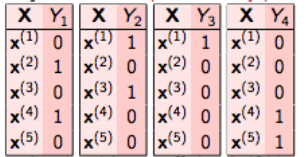   

Evidentemente, este clasificador funciona bien cuando no hay una correlación entre las etiquetas. 

Igualmente, vamos a probar con un clasificador BR, que utiliza un clasificador Gaussian Naive Bayes.


In [ ]:

classifier = BinaryRelevance(GaussianNB())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)


In [ ]:
ac = accuracy_score(y_test,predictions)
hl = hamming_loss(y_test, predictions)
js = jaccard_similarity_score(y_test, predictions)
js_normal = jaccard_similarity_score(y_test, predictions,normalize=False)

print("Accuracy score: {0}".format(ac))
print("Hamming_loss: {0} \nJaccard similarity: {1} \n".format(hl,js,js_normal))

In [ ]:
print(classification_report(y_test, predictions, target_names=lista_comisiones().index.values))

In [ ]:
# initialize Binary Relevance multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

classifier = BinaryRelevance(classifier = SVC())

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

In [ ]:
ac = accuracy_score(y_test,predictions)
hl = hamming_loss(y_test, predictions)
js = jaccard_similarity_score(y_test, predictions)
js_normal = jaccard_similarity_score(y_test, predictions,normalize=False)
print("Accuracy score: {0}".format(ac))
print("Hamming_loss: {0} \nJaccard similarity: {1} \n".format(hl,js,js_normal))

# Segundo clasificador:  Classifier Chain
Este clasificador también se ubica dentro de la categoría de clasificadores que **transforman el problema de multi-label a single-label**.  

Pero en lugar de asignar cada etiqueta individualmente, asigna cada etiqueta teniendo en cuenta no solo las variables independientes sino las etiquetas que ya asignó.

Si hay correlacion de etiquetas, este clasificador debería funcionar mejor que el anterior.

Al igual que en el caso anterior, vamos a probar el Classifier Chain, utiliza como base un clasificador Gaussian Naive Bayes.

In [ ]:
classifier = ClassifierChain(GaussianNB)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(accuracy_score(y_test,predictions))

# Tercer clasificador:  Label Powerset
Este clasificador también corresponde a la categoría de clasificadores que **transforman el problema**.

En este caso, el clasificador transforma el problema de "multi-label" a "multi-class single-label", ya que convierte cada combinación existente de etiquetas, en un único valor de una nueva y única etiqueta, que va a ser la que va a utilizar para resolver el problema.



In [ ]:

classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

print(accuracy_score(y_test,predictions))

In [ ]:
ac = accuracy_score(y_test,predictions)
hl = hamming_loss(y_test, predictions)
js = jaccard_similarity_score(y_test, predictions)
js_normal = jaccard_similarity_score(y_test, predictions,normalize=False)

print("Accuracy score: {0}".format(ac))
print("Hamming_loss: {0} \nJaccard similarity: {1} \n".format(hl,js,js_normal))

In [ ]:
#  Esta métrica no anda con mis datos:
average_precision_score(y_test, predictions.todense())

### Cuarto clasificador: MLkNN
Este clasificador no obedece a la estrategia de transformación sino que es una adaptación de kNN para el problema de la clasificación multi-label.

In [ ]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=2)

# train
classifier.fit(csr_matrix(X_train), csr_matrix(y_train))

# predict
predictions = classifier.predict(csr_matrix(X_test))

In [ ]:
ac = accuracy_score(y_test,predictions)
hl = hamming_loss(y_test, predictions)
js = jaccard_similarity_score(y_test, predictions)
js_normal = jaccard_similarity_score(y_test, predictions,normalize=False)

print("Accuracy score: {0}".format(ac))
print("Hamming_loss: {0} \nJaccard similarity: {1} \n".format(hl,js,js_normal))

### Quinto clasificador: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.cluster import IGraphLabelCooccurenceClusterer
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

# construct base forest classifier
base_classifier = RandomForestClassifier()

# setup problem transformation approach with sparse matrices for random forest
problem_transform_classifier = LabelPowerset(classifier=base_classifier,
    require_dense=[False, False])

# partition the label space using fastgreedy community detection
# on a weighted label co-occurrence graph with self-loops allowed
clusterer = IGraphLabelCooccurenceClusterer('fastgreedy', weighted=True,
    include_self_edges=True)

# setup the ensemble metaclassifier
classifier = LabelSpacePartitioningClassifier(problem_transform_classifier, clusterer)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

### TO DOs:
Text analitics y feature extraction sobre el sumario
GridSearch/ Cross Validaton 


## Text analitics sobre los campos de texto:

In [ ]:
X = proy.iloc[-3000:,:]
X = X['TITULO']
my_stop_words =  get_stop_words('es')
vect = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(3,5))
X = vect.fit_transform(X)
print(vect.get_feature_names()[-300:])